### Preview dataset and some examples with images

Dataset Information:
Total number of images: 2527

Number of images per category:
category
paper        594
glass        501
plastic      482
metal        410
cardboard    403
trash        137
Name: count, dtype: int64

First 5 rows of the dataset:
                                          image_path category
0  data/garbage classification/Garbage classifica...  plastic
1  data/garbage classification/Garbage classifica...  plastic
2  data/garbage classification/Garbage classifica...  plastic
3  data/garbage classification/Garbage classifica...  plastic
4  data/garbage classification/Garbage classifica...  plastic


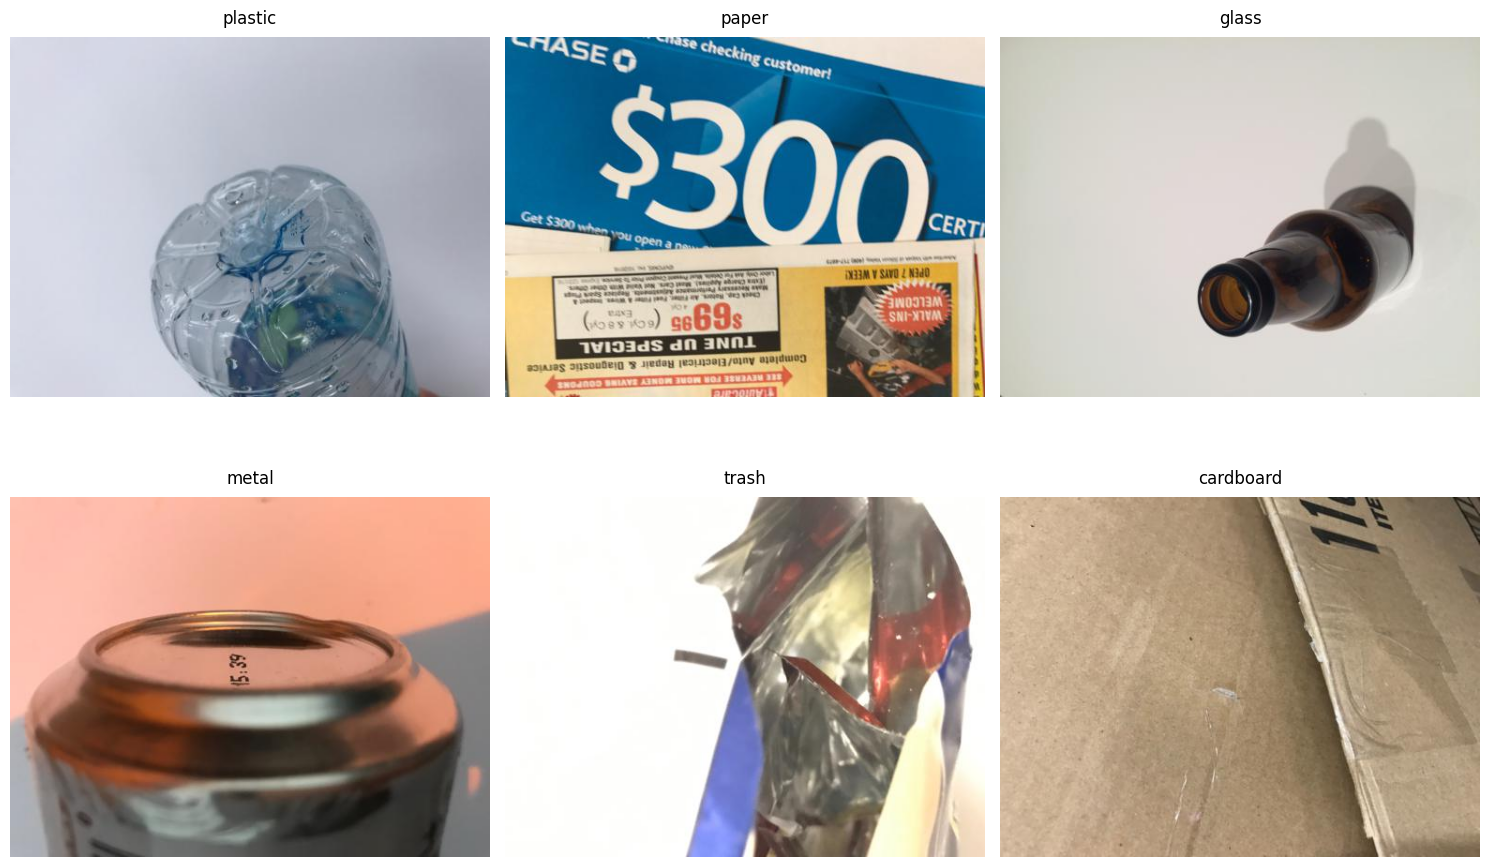


Image Statistics:

Image dimensions statistics:
        width  height
count  2527.0  2527.0
mean    512.0   384.0
std       0.0     0.0
min     512.0   384.0
25%     512.0   384.0
50%     512.0   384.0
75%     512.0   384.0
max     512.0   384.0


In [4]:
# Import required libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path

# Set up matplotlib for better visualization
plt.style.use('default')
plt.rcParams['figure.figsize'] = [15, 10]

# Define the base path to the dataset
base_path = Path('data/garbage classification/Garbage classification')

# Create lists to store the data
image_paths = []
categories = []

# Walk through the directory and collect all image paths and their categories
for category in os.listdir(base_path):
    category_path = base_path / category
    if os.path.isdir(category_path):
        for image_file in os.listdir(category_path):
            if image_file.endswith('.jpg'):
                image_paths.append(str(category_path / image_file))
                categories.append(category)

# Create the DataFrame
df = pd.DataFrame({
    'image_path': image_paths,
    'category': categories
})

# Display basic information about the dataset
print("Dataset Information:")
print(f"Total number of images: {len(df)}")
print("\nNumber of images per category:")
print(df['category'].value_counts())

# Display the first few rows of the DataFrame
print("\nFirst 5 rows of the dataset:")
print(df.head())

# Create a figure with subplots for each category
plt.figure(figsize=(15, 10))

# Get one example from each category
for idx, category in enumerate(df['category'].unique()):
    # Get the first image path for this category
    image_path = df[df['category'] == category]['image_path'].iloc[0]
    
    # Create subplot
    plt.subplot(2, 3, idx + 1)
    
    # Read and display the image
    img = Image.open(image_path)
    plt.imshow(img)
    plt.title(category, fontsize=12, pad=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

# Optional: Display some statistics about image sizes
print("\nImage Statistics:")
image_sizes = []
for path in df['image_path']:
    img = Image.open(path)
    image_sizes.append(img.size)

sizes_df = pd.DataFrame(image_sizes, columns=['width', 'height'])
print("\nImage dimensions statistics:")
print(sizes_df.describe())

*** Split the data into training and testing sets  + Resize***

Data split sizes:
Training set: 1768 images
Validation set: 379 images
Test set: 380 images

Processing images...
Image processing complete!


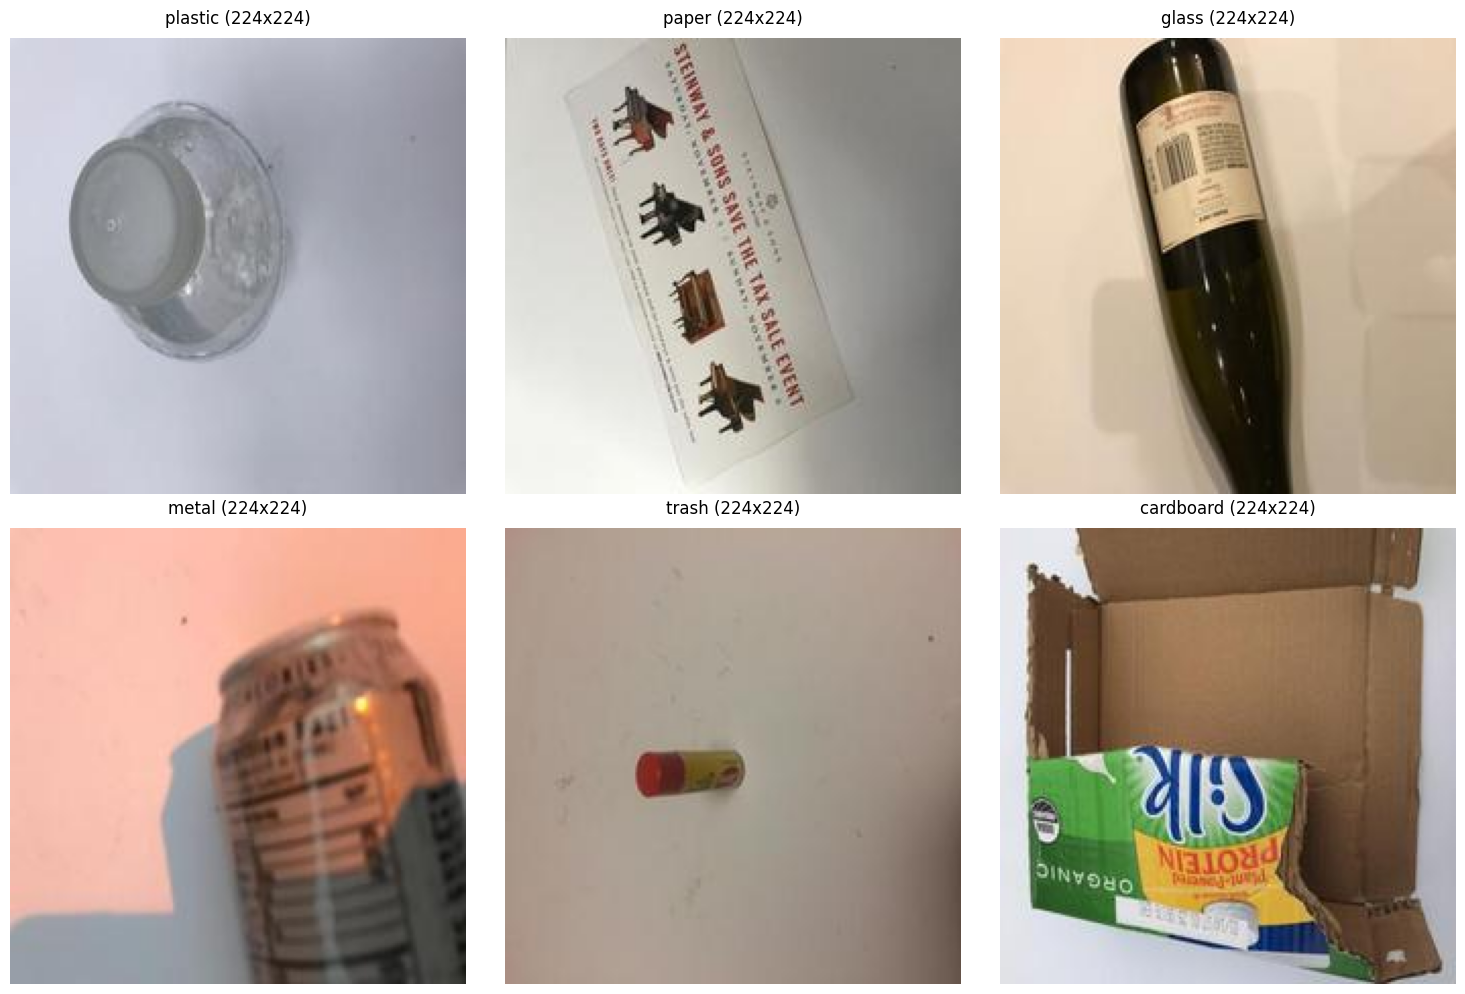

In [5]:
# Split data into train/validation/test sets
from sklearn.model_selection import train_test_split

# First split: 70% train, 30% temp (which will be split into val and test)
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['category'])

# Second split: Split temp into validation and test (50% each of the remaining 30%)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['category'])

print("Data split sizes:")
print(f"Training set: {len(train_df)} images")
print(f"Validation set: {len(val_df)} images")
print(f"Test set: {len(test_df)} images")

# Function to resize and preprocess images
def preprocess_image(image_path, target_size=(224, 224)):
    img = Image.open(image_path)
    img = img.resize(target_size, Image.Resampling.LANCZOS)
    img = img.convert('RGB')  # Ensure image is in RGB format
    return img

# Create directories for processed images
processed_base = Path('data/processed')
for split in ['train', 'val', 'test']:
    (processed_base / split).mkdir(parents=True, exist_ok=True)
    for category in df['category'].unique():
        (processed_base / split / category).mkdir(parents=True, exist_ok=True)

# Process and save images for each split
def process_and_save_split(split_df, split_name):
    for idx, row in split_df.iterrows():
        # Get the image and category
        img = preprocess_image(row['image_path'])
        category = row['category']
        
        # Create new filename
        new_filename = f"{idx}_{Path(row['image_path']).name}"
        save_path = processed_base / split_name / category / new_filename
        
        # Save the processed image
        img.save(save_path)

# Process all splits
print("\nProcessing images...")
process_and_save_split(train_df, 'train')
process_and_save_split(val_df, 'val')
process_and_save_split(test_df, 'test')
print("Image processing complete!")

# Display sample of processed images
plt.figure(figsize=(15, 10))
for idx, category in enumerate(df['category'].unique()):
    # Get the first processed image path for this category
    processed_path = next((processed_base / 'train' / category).glob('*.jpg'))
    
    plt.subplot(2, 3, idx + 1)
    img = Image.open(processed_path)
    plt.imshow(img)
    plt.title(f"{category} (224x224)", fontsize=12, pad=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

### Transfer Learning Setup
Choose a pre-trained model:

MobileNetV2 (fast, lightweight) or EfficientNetB0 (better accuracy).

Freeze base model:

Add custom layers:





In [11]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
import tensorflow as tf

# MobileNetV2

base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# freeze at custom layers

base_model.trainable = False

# add new layers to the basel model from MobileNetV2

""" model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(6, activation='softmax')  # 6 clases
])
 """
# Arquitectura mejorada
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),  # Más neuronas para mejor capacidad
    layers.BatchNormalization(),          # Estabiliza el entrenamiento
    layers.Dropout(0.5),                 # Mayor dropout para evitar overfitting
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(6, activation='softmax')  # 6 categorías
])